# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this :real server data+ https://www.kaggle.com/sohier/30-years-of-european-wind-generation + https://github.com/numenta/NAB <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. This is the very beginning of the process. Still need to do a lot of works!





# What's new in version 5
1. Add Attention based model
2. Add ATTLSTM + FCN
3. still need to think about how to apply the attention mechanism and encoder decoder.
4. Add loss+validation loss plot


In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc

plot_path = "plots/"



In [2]:

# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)





['.ipynb_checkpoints',
 'cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [3]:
if False:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    




In [4]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights
    

In [5]:
# Attention:
# Multi-head Attention:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights
    
    
        
        
# check our Multi-head attention:

# change d to smaller
n_d_model=16


temp_mha = MultiHeadAttention(d_model=n_d_model, num_heads=8)
y = tf.random.uniform((1, 60, n_d_model))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape
    
"""
# Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape
    



"""





"\n# Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.\ndef point_wise_feed_forward_network(d_model, dff):\n    # Two FC layers:\n    return tf.keras.Sequential([\n      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)\n      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)\n  ])\nsample_ffn = point_wise_feed_forward_network(512, 2048)\nsample_ffn(tf.random.uniform((64, 50, 512))).shape\n    \n\n\n\n"

In [6]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

max_tokens = 1440
# encoding
dimension = 200

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(max_tokens, dimension)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])

In [13]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout


In [19]:

# Simply ATT_LSTM:

NB_CLASS = 1
n_cell = 12
n_epoch =15

def generate_model(MAX_TIMESTEPS,MAX_NB_VARIABLES):
    ip = Input(shape=(MAX_TIMESTEPS,MAX_NB_VARIABLES))
    lstm = tf.keras.layers.Bidirectional(LSTM(20))
    x = lstm(ip)
    attention = tf.keras.layers.Attention()
    x = attention([x,x])
    out = Dense(1)(x)
    model = Model(ip, out)
    return model

model = generate_model(1440,5)
model.compile(loss='mae', optimizer='adam')  
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)






Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1440, 5)]    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40)           4160        input_7[0][0]                    
__________________________________________________________________________________________________
attention_5 (Attention)         (None, 40)           0           bidirectional_1[0][0]            
                                                                 bidirectional_1[0][0]            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            41          attention_5[0][0]          

In [20]:
# Let's do it!

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)





Epoch 1/15
441/441 [==============================] - ETA: 0s - loss: 0.1429
Epoch 00001: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 78s 177ms/step - loss: 0.1429 - val_loss: 0.1135
Epoch 2/15
441/441 [==============================] - ETA: 0s - loss: 0.1034
Epoch 00002: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 77s 176ms/step - loss: 0.1034 - val_loss: 0.1076
Epoch 3/15
441/441 [==============================] - ETA: 0s - loss: 0.0919
Epoch 00003: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 79s 178ms/step - loss: 0.0919 - val_loss: 0.0997
Epoch 4/15
441/441 [==============================] - ETA: 0s - loss: 0.0845
Epoch 00004: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 78s 177ms/step - loss: 0.0845 - val_loss: 0.0908
Epoch 5/15
441/441 [==============================] - ETA: 0s - loss: 0.0792
Epoch 00005: saving model to LSTM_ATT/cp.ckpt
441/441 [========

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


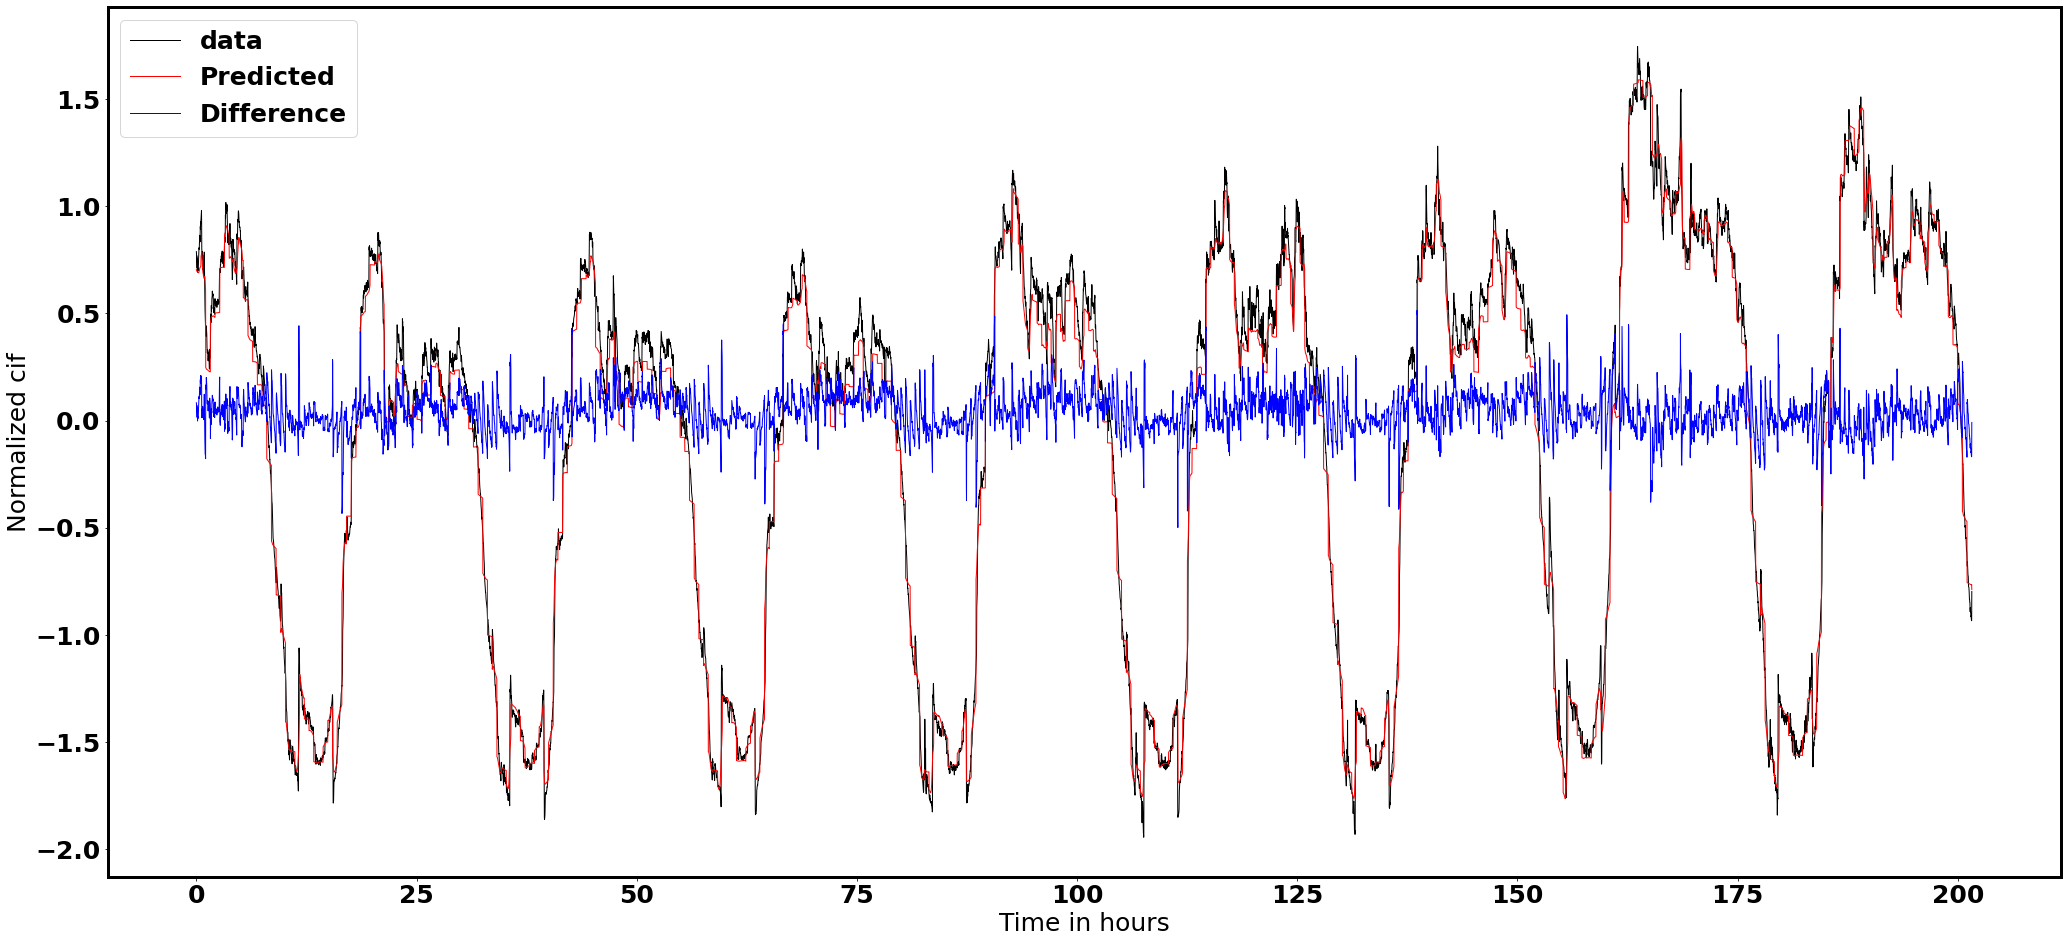

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)
#plt.plot(timeline/60,y_test-y_pre[:,0],"b",label="Difference",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "ATTLSTM_results_5D" + ".png"

fig.savefig(save_path, dpi=150)










In [7]:
# Attention LSTM simple model
delta_t = 1440
n_epoch=40
n_cell = 50
# predict 1 minute for now
N_output=1
N_input = 5
index_name= 0

In [8]:

# calculate previous hour high low:
# convert to seconds
temp = df['time_stamp'] - min(df['time_stamp'])
temp = temp.dt.total_seconds().astype(int)
df["hours"] = temp//3600

h_max = max(df["hours"])+1

for n in range(len(names_array)):
    df[names_array[n]+"_open"] = df[names_array[n]]
    df[names_array[n]+"_close"] = df[names_array[n]]
    df[names_array[n]+"_max"] = df[names_array[n]]
    df[names_array[n]+"_min"] = df[names_array[n]]

for j in range(1,h_max):
    mask_j = df["hours"]==j-1
    max_val = df[mask_j][names_array].max(axis=0).values
    min_val = df[mask_j][names_array].max(axis=0).values
    open_val = df[mask_j][names_array].values[0,:]
    close_val = df[mask_j][names_array].values[-1,:]
    mask_i = df["hours"]==j
    r = df[mask_i][names_array].shape[0]
    df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
    df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))
    
    df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
    df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    




In [9]:
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute


checkpoint_path = "LSTM_ATT/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

name_mod = [names_array[index_name],names_array[index_name]+"_open",names_array[index_name]+"_close",names_array[index_name]+"_max",names_array[index_name]+"_min",]

np_scaled = min_max_scaler.fit_transform(df[name_mod])

df_scaled = pd.DataFrame(np_scaled,columns=name_mod)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df_scaled[i:i+delta_t][name_mod].values

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)



Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent


In [14]:
# model:

NB_CLASS = N_output

def squeeze_excite_block(input):

    filters = input._shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

def generate_model(MAX_TIMESTEPS,MAX_NB_VARIABLES):
    ip = Input(shape=(MAX_TIMESTEPS,MAX_NB_VARIABLES))
    # split into x and y two channels

    x = Masking()(ip)
    x = LSTM(n_cell)(x)
    # Add attention here:
    attention = tf.keras.layers.Attention()
    x = attention([x,x])
    
    x = Dropout(0.8)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)
    # combine
    x = concatenate([x, y])

    #out = Dense(NB_CLASS, activation='softmax')(x)
    # For regression model use MAE
    out = Dense(N_output)(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

In [15]:
model = generate_model(delta_t,5)

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)






Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1440, 5)]    0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 5, 1440)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5, 128)       1474688     permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 128)       512         conv1d[0][0]                     
______________________________________________________________________________________________

In [22]:
# visualize:
import keras
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [25]:
# Let's do it!

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)

# history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[tensorboard_callback], verbose=1, shuffle=False)


Epoch 1/10
441/441 [==============================] - 50s 114ms/step - loss: 0.1630 - val_loss: 0.1142
Epoch 2/10
441/441 [==============================] - 39s 89ms/step - loss: 0.1083 - val_loss: 0.0929
Epoch 3/10
441/441 [==============================] - 40s 90ms/step - loss: 0.0967 - val_loss: 0.1005
Epoch 4/10
441/441 [==============================] - 40s 91ms/step - loss: 0.0874 - val_loss: 0.0841
Epoch 5/10
441/441 [==============================] - 40s 90ms/step - loss: 0.0810 - val_loss: 0.0688
Epoch 6/10
441/441 [==============================] - 40s 91ms/step - loss: 0.0752 - val_loss: 0.0741
Epoch 7/10
441/441 [==============================] - 40s 90ms/step - loss: 0.0701 - val_loss: 0.0771
Epoch 8/10
441/441 [==============================] - 40s 90ms/step - loss: 0.0661 - val_loss: 0.0860
Epoch 9/10
441/441 [==============================] - 40s 90ms/step - loss: 0.0633 - val_loss: 0.0559
Epoch 10/10
441/441 [==============================] - 40s 91ms/step - loss: 0.06

In [44]:
import tensorboard
%load_ext tensorboard



In [47]:
%tensorboard --logdir logsa

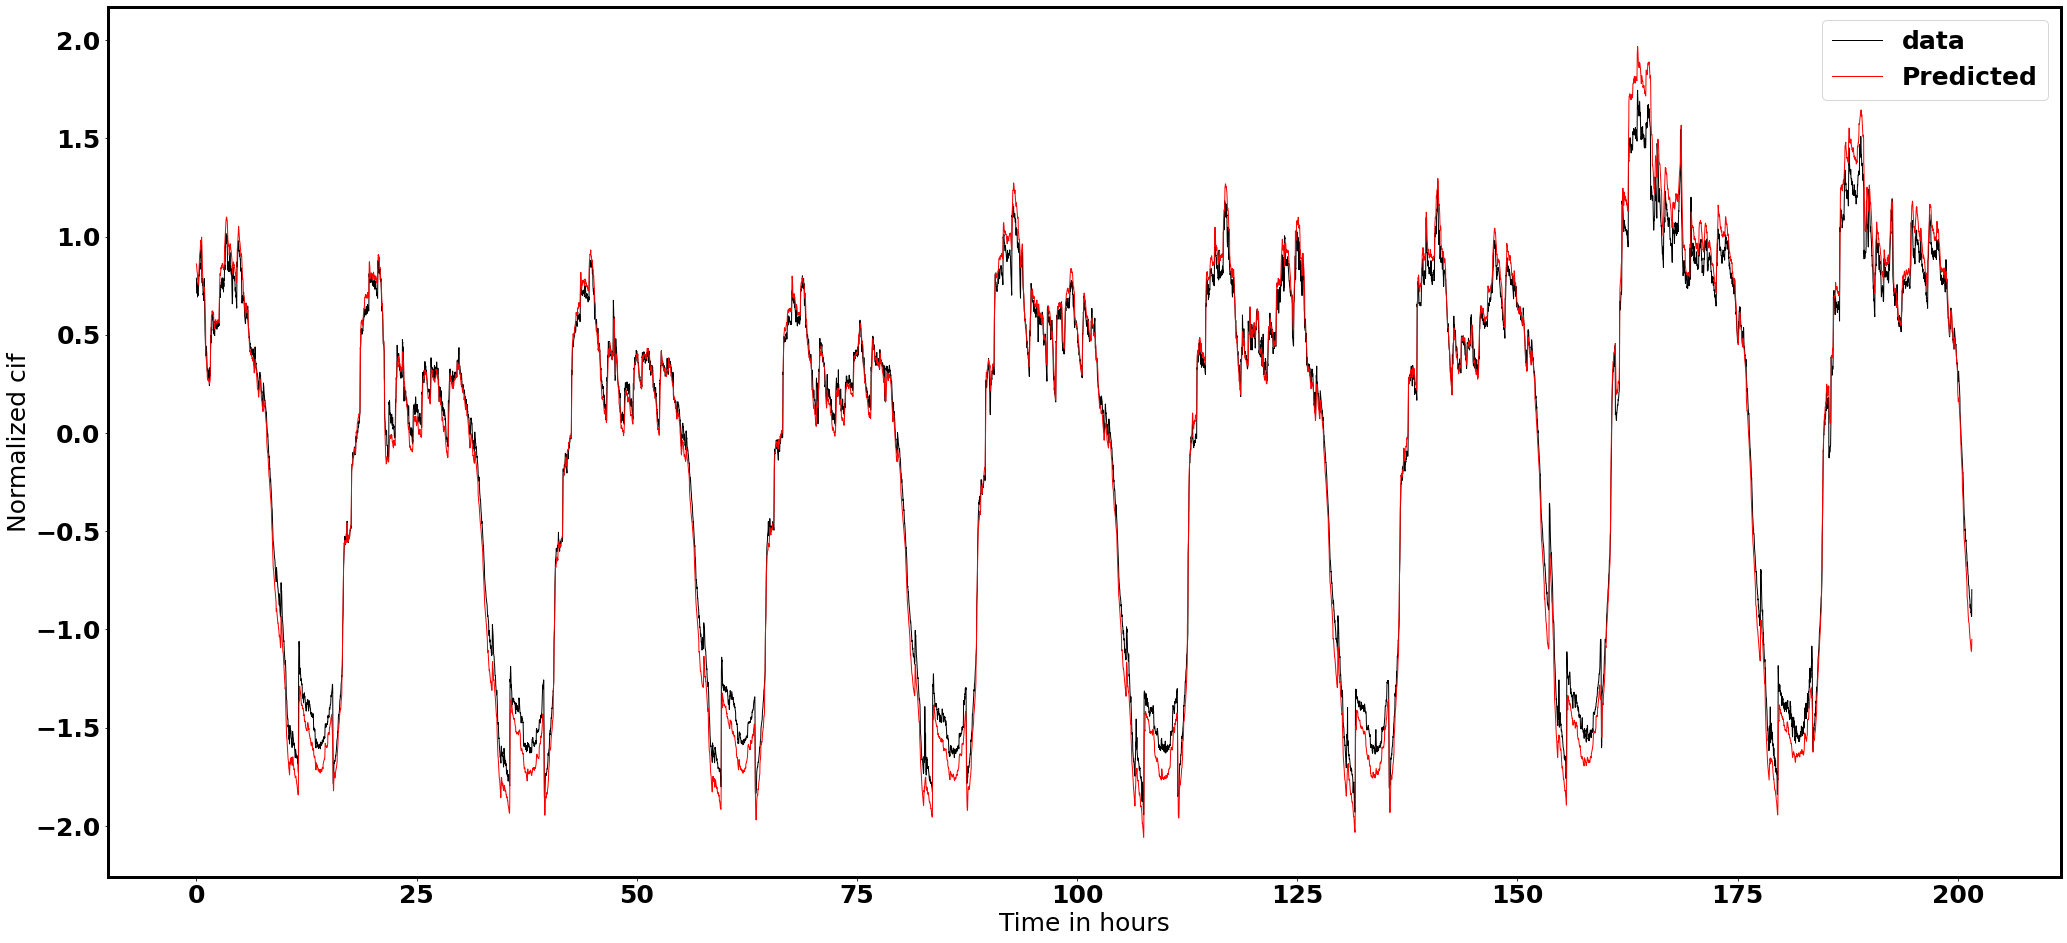

In [121]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "ATTLSTM_FCN_results_5D" + ".png"

fig.savefig(save_path, dpi=150)









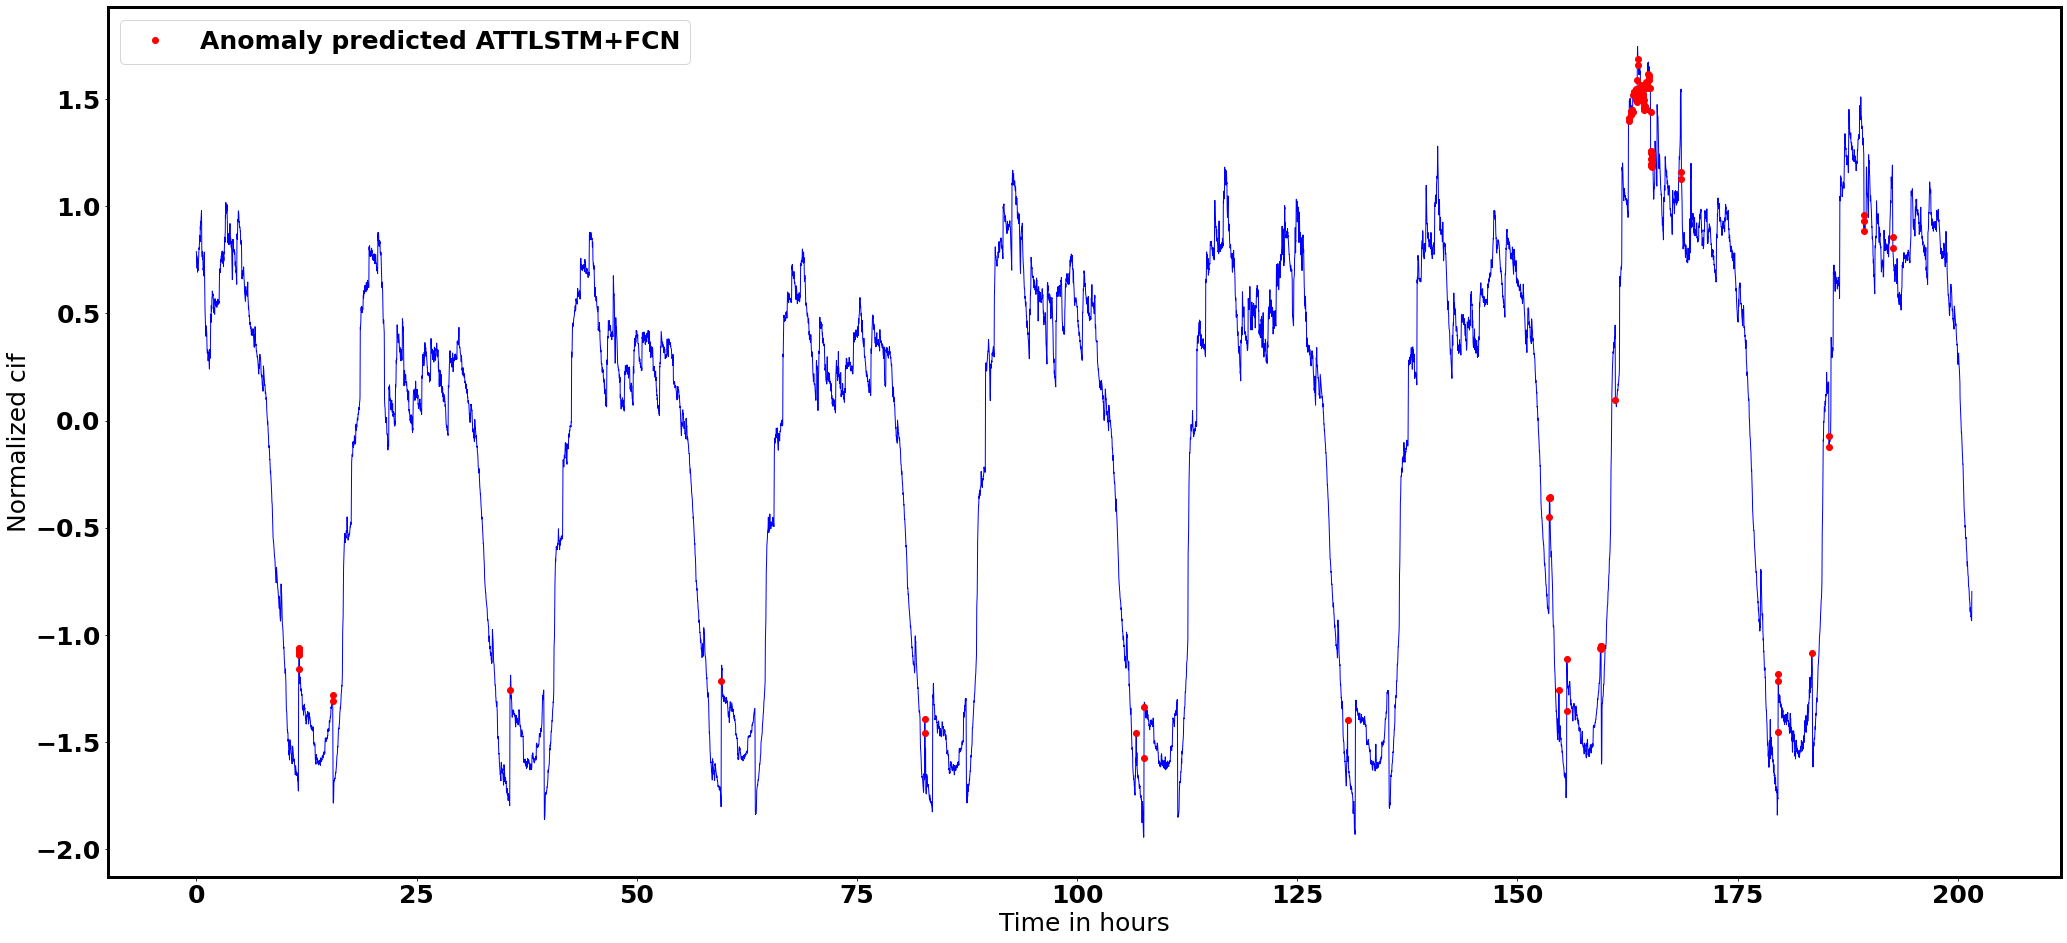

In [122]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted ATTLSTM+FCN",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "ATTLSTM_FCN_anomaly_prediction_5D" + ".png"

fig.savefig(save_path, dpi=150)










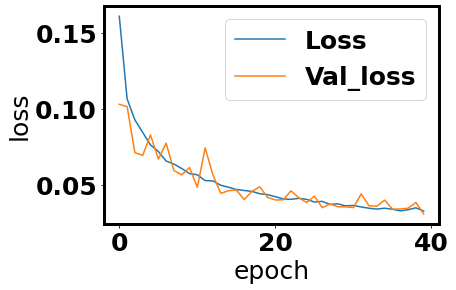

In [123]:
# Only for diagnostic
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

## Attention without LSTM:

In [108]:
# Attention simple model
delta_t = 1440
n_epoch=10
n_cell = 50
# predict 1 minute for now
N_output=1
N_input = 5
index_name= 0


In [109]:
# model:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention
NB_CLASS = N_output

def squeeze_excite_block(input):

    filters = input._shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

def generate_model(MAX_TIMESTEPS,MAX_NB_VARIABLES):
    ip = Input(shape=(MAX_TIMESTEPS,MAX_NB_VARIABLES))
    # split into x and y two channels

    x = Masking()(ip)

    # CNN+attention
    cnn_layer = tf.keras.layers.Conv1D(
    filters=200,
    kernel_size=4,padding='same')
    a1 = cnn_layer(x)
    a2 = cnn_layer(x)
    
    attention = tf.keras.layers.Attention()
    x2 = attention([a1,a2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    x = concatenate([x, x2])
    x = Dropout(0.8)(x)
    # convert to 1d pooling
    
    

    
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)
    # combine (Optional)
    print("check",y.shape,x.shape)
    x = concatenate([x, y])

    #out = Dense(NB_CLASS, activation='softmax')(x)
    # For regression model use MAE
    out = Dense(N_output)(x)
    print(out.shape)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

In [110]:
model = generate_model(delta_t,5)

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)







check (None, 128) (None, 205)
(None, 1)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 1440, 5)]    0                                            
__________________________________________________________________________________________________
permute_13 (Permute)            (None, 5, 1440)      0           input_28[0][0]                   
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 5, 128)       1474688     permute_13[0][0]                 
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 5, 128)       512         conv1d_47[0][0]                  
___________________________________________________

In [111]:

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)




Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.5658
Epoch 00001: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 106s 241ms/step - loss: 0.5658 - val_loss: 0.7671
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.3253
Epoch 00002: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 103s 234ms/step - loss: 0.3253 - val_loss: 1.0139
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.2639
Epoch 00003: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 103s 234ms/step - loss: 0.2639 - val_loss: 0.8707
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.2500
Epoch 00004: saving model to LSTM_ATT/cp.ckpt
441/441 [==============================] - 103s 234ms/step - loss: 0.2500 - val_loss: 1.0599
Epoch 5/10
441/441 [==============================] - ETA: 0s - loss: 0.2438
Epoch 00005: saving model to LSTM_ATT/cp.ckpt
441/441 [====

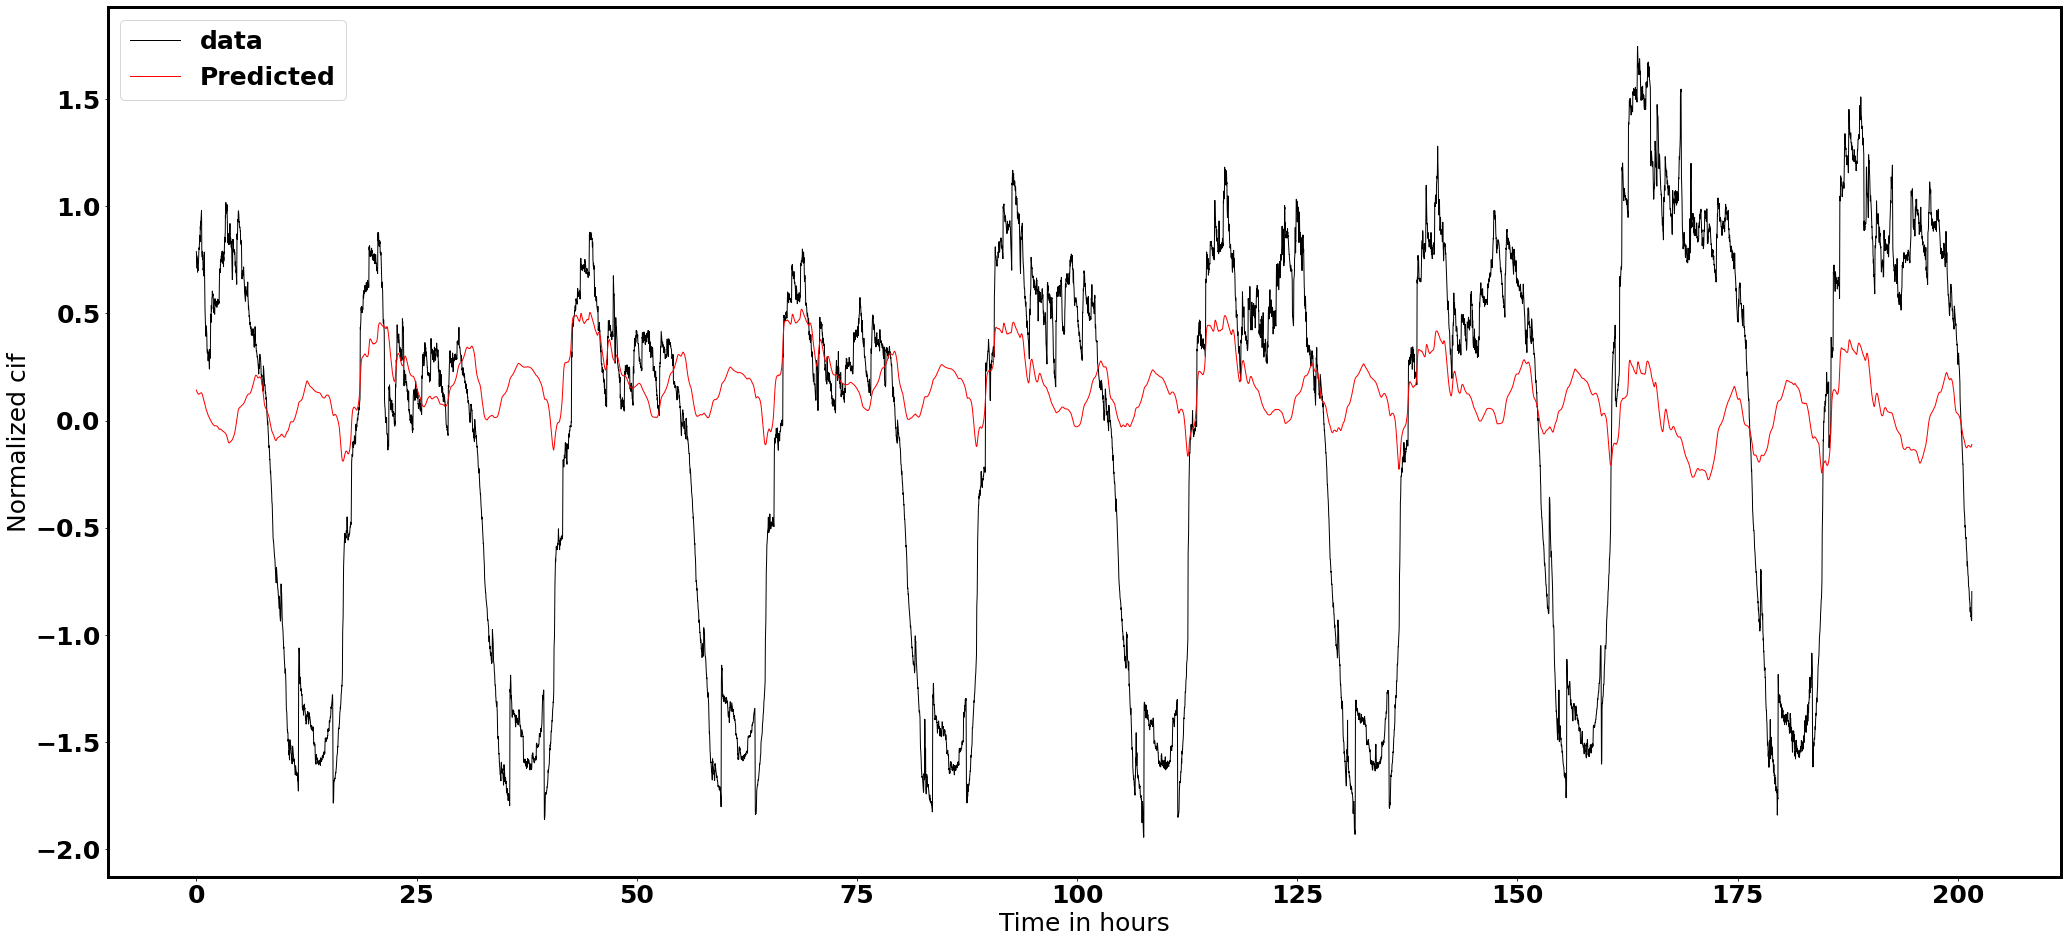

In [112]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "ATT_FCN_results_5D" + ".png"

fig.savefig(save_path, dpi=150)










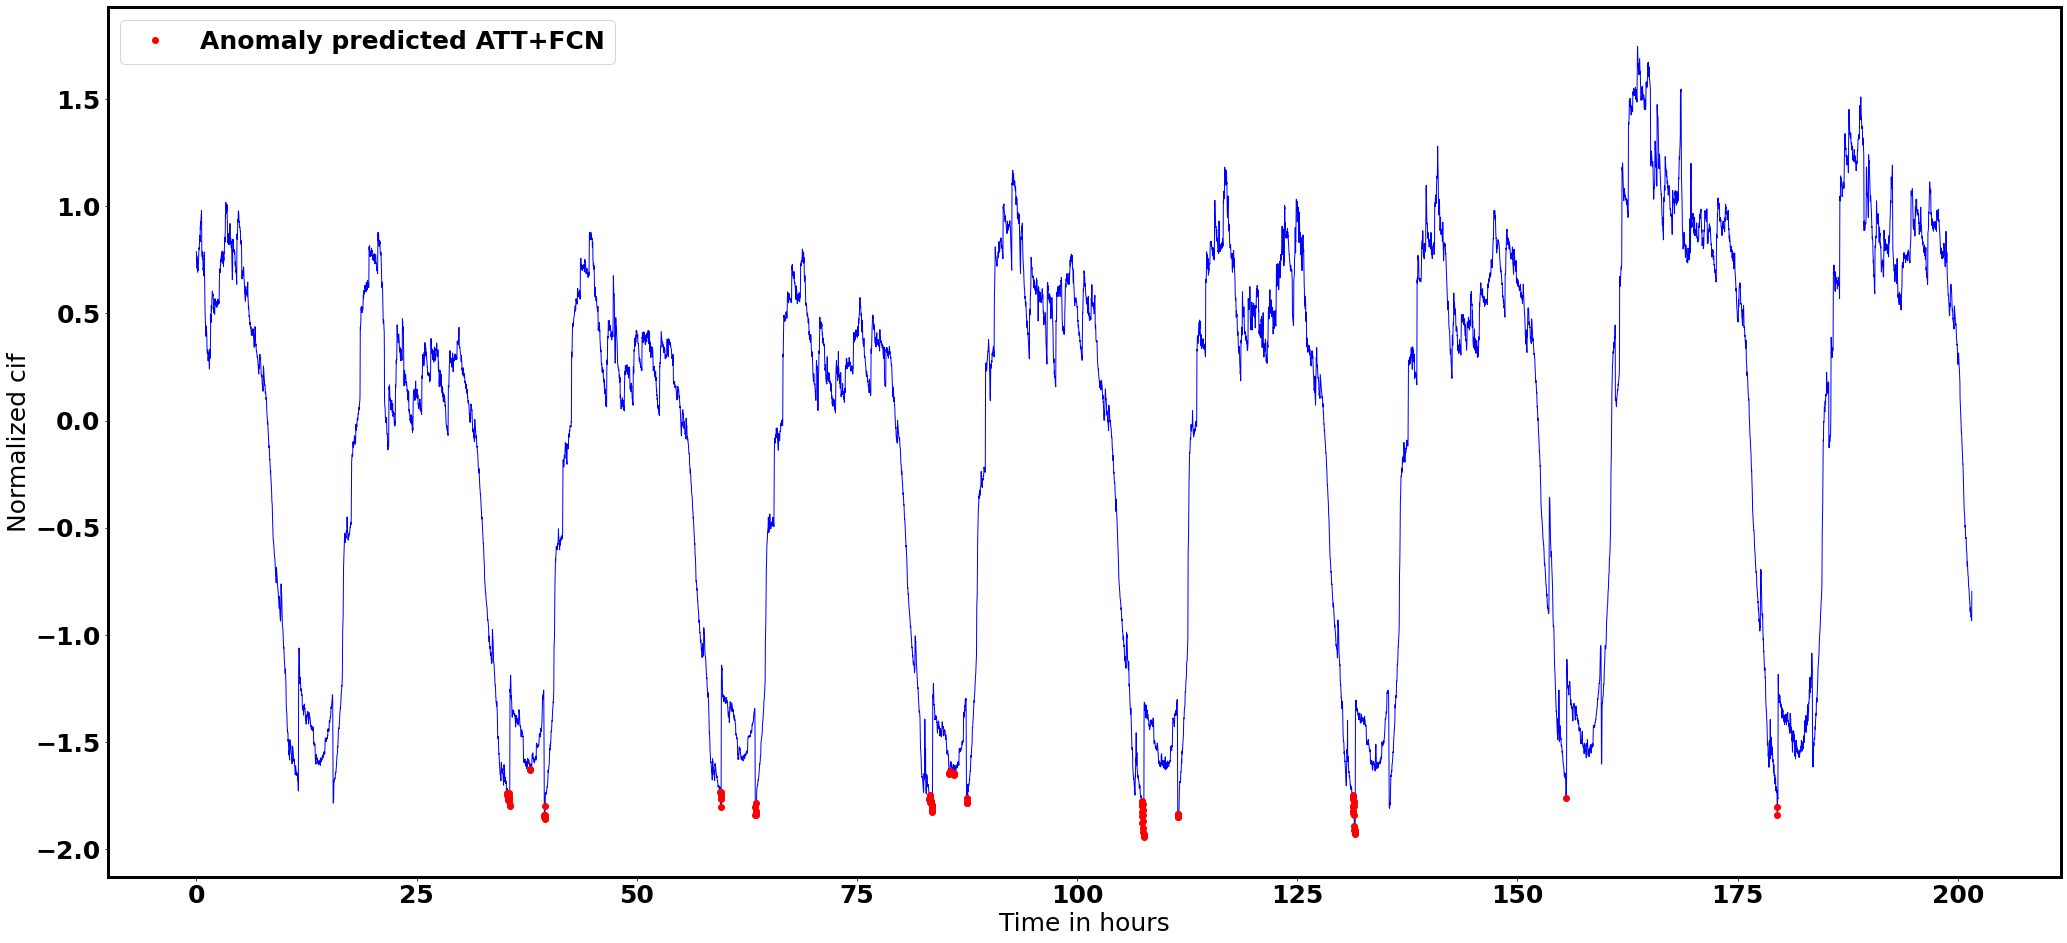

In [113]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted ATT+FCN",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "ATT_FCN_anomaly_prediction_5D" + ".png"

fig.savefig(save_path, dpi=150)











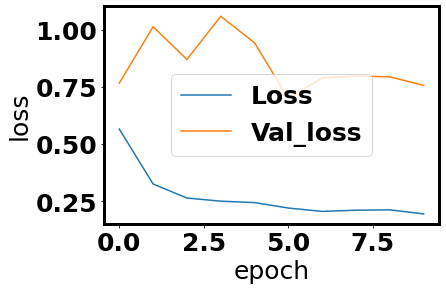

In [114]:
# Only for diagnostic
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()